# Smoking and Toking on Twitter

In this notebook, we perform an initial analysis to estimate the demographics of Twitter users who mention e-cigarettes or marijuana online.

In [229]:
from collections import Counter, defaultdict
import cPickle
import csv
import datetime
import gzip
import itertools
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

DATA='/data/2/uic/'

In [2]:
def read_csv(filename, fields=['text', 'svm', 'hand_label', 'posted_time', 'username']):
    f = gzip.open(filename, 'rb')
    csvr = csv.DictReader(f, delimiter=',', quotechar='"')
    for row in csvr:
        yield dict([(k, row[k]) for k in fields])

In [3]:
# Read all "organic" tweets.
raw_tweets = [r for r in read_csv(DATA + '/ecig/ecig.csv.gz') if r['svm'] == '-']
print 'read', len(raw_tweets), '"organic" tweets'

read 992633 "organic" tweets


**Let's plot some descriptive statistics of the data.**

531655 users
20 most common users [('DallasEcig', 14640), ('DragonflyEcig', 14278), ('LewisvilleECig', 4837), ('gjvape', 4541), ('maverick7768', 4449), ('Vapornine1', 4105), ('DFWVaporsStore', 2901), ('RokkiMoon', 2301), ('royalvapornet', 2183), ('GordonAlanBeard', 2154)]
526530 users with 10 or fewer tweets
418315 users with 1 tweet
Top 1% of users account for 25.6% of tweets


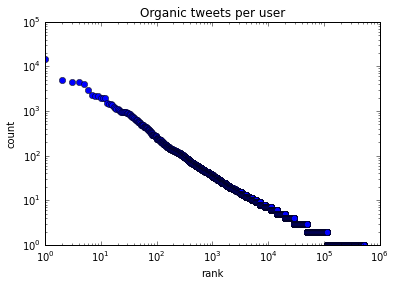

In [4]:
# Tweets by user.
def tweets_per_user(tweets):
    counts = Counter(t['username'] for t in tweets)
    print '%d users' % len(counts)
    print '20 most common users', counts.most_common(10)
    print '%d users with 10 or fewer tweets' % len([x for x in counts.iteritems() if x[1] <= 10])
    print '%d users with 1 tweet' % len([x for x in counts.iteritems() if x[1] == 1])
    print 'Top 1%% of users account for %.1f%% of tweets' % (100. * sum(x[1] for x in counts.most_common(int(.01 * len(counts)))) / len(tweets))
    plt.figure()
    plt.plot(sorted(counts.values(), reverse=True), 'bo')
    plt.xlabel('rank')
    plt.ylabel('count')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Organic tweets per user')
    plt.show()
    
tweets_per_user(raw_tweets)

Thus, there are a small number of accounts tweeting a lot, that appear to be ecigarette companies.

most popular months:
[(datetime.date(2013, 9, 1), 158669), (datetime.date(2013, 8, 1), 114894), (datetime.date(2013, 4, 1), 110735), (datetime.date(2013, 6, 1), 96447), (datetime.date(2013, 7, 1), 94180), (datetime.date(2013, 3, 1), 90870), (datetime.date(2013, 5, 1), 84692), (datetime.date(2013, 2, 1), 65971), (datetime.date(2013, 1, 1), 62883), (datetime.date(2012, 12, 1), 46271)]


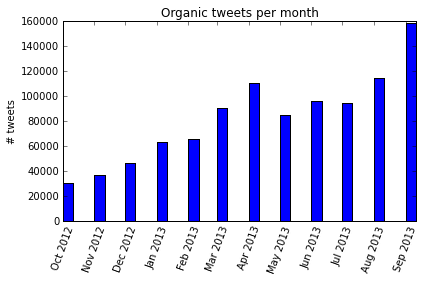

In [5]:
# Tweets by month.
def format_month(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0'+parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

def tweets_by_month(tweets):
    months = Counter(format_month(x['posted_time']) for x in tweets)
    print 'most popular months:\n', months.most_common(10)
    #keys = sorted(months.keys())
    keys = [d for d in sorted(months.keys()) if d is not None]
    plt.figure()
    ax = plt.subplot(111)
    plt.xticks(rotation=70) 
    ax.bar(keys, [months[k] for k in keys], width=10)
    ax.xaxis_date()
    plt.title('Organic tweets per month')
    plt.ylabel('# tweets')
    plt.tight_layout()
    plt.show()
    
tweets_by_month(raw_tweets)

**Filter the data.**

In [6]:
# Retain tweets from users who have tweeted 3 or fewer times.
user_counts = Counter(t['username'] for t in raw_tweets)
tweets = [t for t in raw_tweets if user_counts[t['username']] <= 3]
print '%d tweets from users who tweeted 3 or fewer times' % len(tweets)

606821 tweets from users who tweeted 3 or fewer times


most popular months:
[(datetime.date(2013, 9, 1), 101414), (datetime.date(2013, 8, 1), 75937), (datetime.date(2013, 6, 1), 62340), (datetime.date(2013, 7, 1), 58455), (datetime.date(2013, 3, 1), 57739), (datetime.date(2013, 5, 1), 50415), (datetime.date(2013, 4, 1), 48421), (datetime.date(2013, 2, 1), 40462), (datetime.date(2013, 1, 1), 39745), (datetime.date(2012, 12, 1), 28786)]


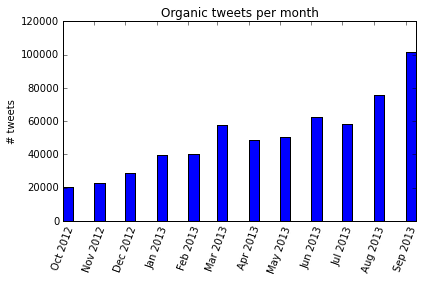

In [7]:
tweets_by_month(tweets)

In [8]:
print '\n'.join(x['text'] for x in tweets[:10])

Getting an e cig tomorrow :)
nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4
Smoking an e-cig is the equivalent to smoking smarties. You look like a faggot
Advertise Ecigs HQ on Social Media Sites http://t.co/KmE6lHcq
Photo: pizzzatime: nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/neyow8Go
#starwars RT @pizzzatimes nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/NcAlTYRA
Ecig finally died #rip
I'm defo buying an E-Cig tomorrow!
pizzzatime: nickdrake: C3P0 Enjoys a cigarette break during filming.  C3P0 I AM EXTREMELY DISAPPOINTED IN YOU. http://t.co/N3psXH9o
lol at the random kid who asked me for a cigarette #smokefree #fuckyourhabit


In [9]:
# Remove retweets
tweets = [t for t in tweets if t['text'][:2] != 'RT']
print '%d non RT tweets from users who tweeted 3 or fewer times' % len(tweets)

444273 non RT tweets from users who tweeted 3 or fewer times


most popular months:
[(datetime.date(2013, 9, 1), 70888), (datetime.date(2013, 8, 1), 54519), (datetime.date(2013, 6, 1), 44472), (datetime.date(2013, 7, 1), 42362), (datetime.date(2013, 3, 1), 41558), (datetime.date(2013, 5, 1), 37254), (datetime.date(2013, 4, 1), 35881), (datetime.date(2013, 2, 1), 31779), (datetime.date(2013, 1, 1), 31178), (datetime.date(2012, 12, 1), 20837)]


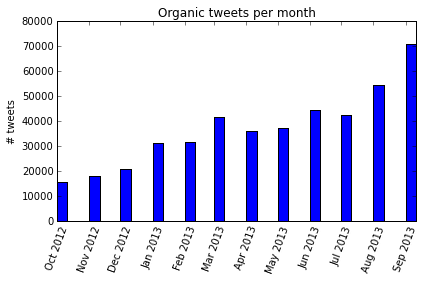

In [10]:
tweets_by_month(tweets)

In [11]:
print '\n'.join(x['text'] for x in tweets[::10000])

Getting an e cig tomorrow :)
he with the electronic cigarette and his british accent back OMG OMG
@cameronbrock4L yeah, but I also read a thing you an jut out your weed in the electronic cig an it just vaporizes is idk if it really works
Dem e-cigs where it's at #NOT
Everyone is passing around the ECig and trying it out... yeah they're that drunk haha
This e cig is becoming far to addicting
ONE TIME IN ENGLISH THIS STUPID GUY TOOK OUT AN ELECTRIC CIGARETTE AND STARTED SMOKING IT IN THE MIDDLE OF C L A S S
Love my e cig :)
Ecigs are so gay if I see you holding one of those I automatically assume you're a faggot
@IkimHassan hahaha damn tu scene penting kot terutama sebelum buka plastik supaya sama padat sama rata...damn e-cig brotherhood killa
Would you like to quit smoking? Research eCigarettes, make your decision today! #eCigs1 http://t.co/tJ02Ix6p
E-Cig for only P750!!! Order now!!!   DOUBLE THE FUN CAUSE THE EGO - CE5 SET CONTAINS 2 E-CIG!  Box contains... http://t.co/LxFtZ81ZBh
Thin

In [12]:
print '%d users remain' % len(set(t['username'] for t in tweets))

368418 users remain


In [13]:
# Use the twdemo tool to predict demographics: https://github.com/tapilab/twdemo
# !cd $DATA && twdemo predict --input sample.json -t u > demo.json
# !cd $DATA && twdemo predict --input sample2.json -t u > demo2.json
# !cd $DATA && twdemo predict --input random_users.json -t u > random_users_demo.json

In [263]:
# Read predictions and normalize scores.
MIN_FRIENDS=50  # only include users who follow this many users.

def divide_by(demo, denominator):
    # Divide all demographic values by this number (e.g., number of friends).
    for category in demo:
        for label in demo[category]:
            demo[category][label] /= denominator
    
def norm(demo):
    for category in demo:
        total = sum(demo[category][label] for label in demo[category])
        for label in demo[category]:
            if total > 0:
                demo[category][label] /= 1. * total
         
def classify(user2demo):
    """ Set most probable demographics to 1."""
    result = {}
    for user, demo in user2demo.iteritems():
        newdemo = defaultdict(lambda: {})
        for category in demo:
            besti = np.argmax([demo[category][label] for label in demo[category]])
            for i, label in enumerate(demo[category]):
                if i == besti:
                    newdemo[category][label] = 1.
                else:
                    newdemo[category][label] = 0.
        result[user] = newdemo
    return result
    
def read_demographics(fnames):
    user2demo = dict()
    for fname in fnames:
        for line in open(fname, 'rt'):
            try:
                js = json.loads(line)
                if len(js['friend_list']) >= MIN_FRIENDS:
                    demo = js['user_demographics']
                    #print 'demo:', demo
                    divide_by(demo, len(js['friend_list']))
                    #print 'normed demo:', demo
                    norm(demo)
                    user2demo[js['screen_name'].lower()] = demo
            except Exception as e:
                print e
                pass  # silently skip bad lines
    return user2demo

user2demo = read_demographics([DATA + '/ecig/demo.json', DATA + '/ecig/demo2.json', DATA + '/ecig/demo2.2.json', 
                               DATA + '/ecig/demo2.3.json'])
print 'read %d users with demographics' % len(user2demo)

No JSON object could be decoded
No JSON object could be decoded
No JSON object could be decoded
No JSON object could be decoded
Unterminated string starting at: line 1 column 2 (char 1)
read 3190 users with demographics


In [264]:
baseline2demo = read_demographics([DATA + '/ecig/random_users_demo.json'])
print 'read %d basline users with demographics' % len(baseline2demo)

No JSON object could be decoded
read 682 basline users with demographics


In [265]:
def average_demos(demo_list, categories):
    average = defaultdict(lambda: {})
    for category, labels in categories.items():
        for label in labels:
            average[category][label] = np.mean([demo[category][label] for demo in demo_list])
    return average

def divide_by_baseline(month_avg, baseline_avg, categories):
    for cat, labels in categories.iteritems():
        for label in labels:
            month_avg[cat][label] /= baseline_avg[cat][label]
    return month_avg
# user2demo_diff = diff_w_baseline(user2demo, baseline2demo, categories)


In [266]:
# some user accounts are obviously not personal:
blacklist = set(['vapstor', 'e_commerceguru'])
def remove_blacklist(user2demo, blacklist):
    return dict((k, v) for k, v in user2demo.iteritems() if k not in blacklist)

user2demo = remove_blacklist(user2demo, blacklist)
# user2demo_diff = remove_blacklist(user2demo_diff, blacklist)
    

In [267]:
# Print top examples for each class.
def sort_demo(demo, category, label):
    return sorted(demo.items(), key=lambda x: x[1][category][label], reverse=True)

categories = {'Education': ['No College', 'College', 'Grad School'],
              'Children': ['No Kids', 'Has Kids'],
              'Income': ['$0-50k', '$50-100k', '$100-150k', '$150k+'],
              'Gender': ['Male', 'Female'],
              'Age': ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
              'Ethnicity': ['Caucasian', 'Hispanic', 'African American', 'Asian']}
for category, labels in categories.iteritems():
    for label in labels:
        print category, '\t', label
        for user, demo in sort_demo(user2demo, category, label)[:5]:
            print '\t', user, demo[category][label]

Gender 	Male
	_stay_trippiiin 1.0
	patrickmowgli 1.0
	mightygooner49 1.0
	loco_x_pita 1.0
	pasbrucewayne 1.0
Gender 	Female
	tao_ 1.0
	abbievankempen 1.0
	c_a_peters 1.0
	chamssidz 1.0
	eqsounds 1.0
Age 	18-24
	ontokki96 1.0
	pickledcowtoes 1.0
	syupeoelpeu 1.0
	gaangsta_piips 1.0
	moubag 1.0
Age 	25-34
	actor51 0.983888119953
	maxrameau 0.878681428364
	forkintheroadvv 0.816731986335
	cigalectric1 0.718862658872
	citysprawlnvmag 0.70544130505
Age 	35-44
	mynkop 0.799669268081
	rnog02 0.596819623701
	justmegee 0.499419208142
	luenell 0.483826159727
	gshopaholic 0.467715349353
Age 	45-54
	babbeykels 0.582914695912
	martinschultz31 0.569716652805
	augustapreston_ 0.513126672354
	eqsounds 0.51175831671
	mokranelekabyle 0.469949948699
Age 	55-64
	arshaabuddee 0.5136787669
	coolfallenrain 0.489907550999
	rorialina 0.468103431662
	i_s1lent_i 0.451217334696
	inquisitrworld 0.446647455553
Age 	65+
	fkariuki 0.387782212009
	keithybabes2k13 0.320572895621
	maribeltracey46 0.31300955823
	ramadzana

In [268]:
#classify(user2demo)
#classify(baseline2demo)

In [269]:
# Print baseline demographics of all Twitter users.
baseline_avg = average_demos(baseline2demo.values(), categories)
print json.dumps(baseline_avg, indent=2)

{
  "Gender": {
    "Male": 0.52458525434244441, 
    "Female": 0.44608923246107468
  }, 
  "Age": {
    "55-64": 0.064138207682156639, 
    "25-34": 0.20952742737126548, 
    "65+": 0.045184041207915616, 
    "18-24": 0.44117349580123383, 
    "45-54": 0.10987965631450212, 
    "35-44": 0.096372831446973214
  }, 
  "Income": {
    "$100-150k": 0.067800857212014953, 
    "$0-50k": 0.74509716579081375, 
    "$50-100k": 0.10127805671104416, 
    "$150k+": 0.055032131429822148
  }, 
  "Education": {
    "College": 0.14486315081070775, 
    "No College": 0.70028454088333025, 
    "Grad School": 0.12112796813000898
  }, 
  "Children": {
    "No Kids": 0.40186692621357539, 
    "Has Kids": 0.56734128493011959
  }, 
  "Ethnicity": {
    "Hispanic": 0.28569895447838345, 
    "African American": 0.33083905475827718, 
    "Caucasian": 0.26503270825895819, 
    "Asian": 0.089103769307900302
  }
}


In [270]:
# Print average for all users with demographics in ecig data.
print json.dumps(average_demos(user2demo.values(), categories), indent=2 )

{
  "Gender": {
    "Male": 0.59053748195271949, 
    "Female": 0.39064194088291415
  }, 
  "Age": {
    "55-64": 0.087210930761500841, 
    "25-34": 0.27786805927558383, 
    "65+": 0.045041631946219275, 
    "18-24": 0.37930710099323101, 
    "45-54": 0.10570749791401626, 
    "35-44": 0.083534791656500365
  }, 
  "Income": {
    "$100-150k": 0.090686820914552005, 
    "$0-50k": 0.6820558299101368, 
    "$50-100k": 0.11814385060671198, 
    "$150k+": 0.088724539973868977
  }, 
  "Education": {
    "College": 0.21570493327359874, 
    "No College": 0.55818992187260763, 
    "Grad School": 0.20226574711226286
  }, 
  "Children": {
    "No Kids": 0.53752557527949174, 
    "Has Kids": 0.44083076098148705
  }, 
  "Ethnicity": {
    "Hispanic": 0.2727402779767214, 
    "African American": 0.22295009527584403, 
    "Caucasian": 0.3653691885917546, 
    "Asian": 0.11980618470524078
  }
}


In [271]:
# Print average for all users with demographics divided by baseline demographics
demo_vs_baseline = divide_by_baseline(average_demos(user2demo.values(), categories), baseline_avg, categories)
print json.dumps(demo_vs_baseline, indent=2) 

{
  "Gender": {
    "Male": 1.1257226105086477, 
    "Female": 0.87570358676389082
  }, 
  "Age": {
    "55-64": 1.3597344533492954, 
    "25-34": 1.3261655658245846, 
    "65+": 0.99684823982341375, 
    "18-24": 0.85976855954221676, 
    "45-54": 0.96202974653884854, 
    "35-44": 0.86678776997917029
  }, 
  "Income": {
    "$100-150k": 1.3375468193709126, 
    "$0-50k": 0.91539179213791855, 
    "$50-100k": 1.166529596275603, 
    "$150k+": 1.6122315757842658
  }, 
  "Education": {
    "College": 1.4890255531957863, 
    "No College": 0.79709016733185878, 
    "Grad School": 1.6698517298264852
  }, 
  "Children": {
    "No Kids": 1.3375710719568386, 
    "Has Kids": 0.77701160252384049
  }, 
  "Ethnicity": {
    "Hispanic": 0.95464219837513431, 
    "African American": 0.67389291581291488, 
    "Caucasian": 1.3785815003435713, 
    "Asian": 1.344569209987599
  }
}


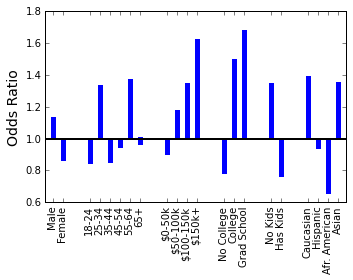

In [272]:
# Print bar chart of ecig demo / baseline
def plot_demo_or(demo, categories):
    plt.figure(figsize=(5,4))
    posi = 1
    positions = []
    xlabels = []
    for cat, labels in categories.items():
        for label in labels:
            adj = 1.02 if demo[cat][label] > 1 else .98
            plt.plot([posi,posi], [adj,demo[cat][label]], 'b-', linewidth=5, solid_capstyle='projecting')
            if label == 'African American':
                label = 'Afr. American'
            xlabels.append(label)
            positions.append(posi)
            posi += 1.2
        posi += 2
    plt.xticks(positions, xlabels, rotation=90)
    plt.ylabel('Odds Ratio', size=14)
    plt.xlim(min(positions)-1, max(positions)+1)
    plt.axhline(y=1, color='k', linewidth=2)
    plt.tight_layout()
    plt.savefig('or.pdf', bbox_inches='tight')
    plt.show()
    
plot_demo_or(demo_vs_baseline, categories)    

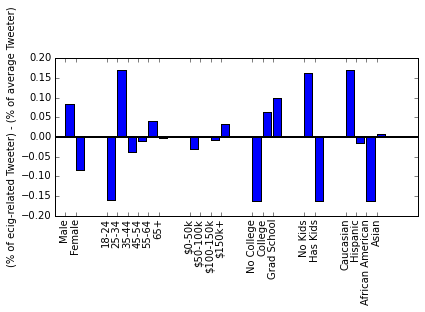

{
  "Gender": {
    "Male": 0.084480106852309, 
    "Female": -0.084480106852309056
  }, 
  "Age": {
    "35-44": -0.03797046843551883, 
    "25-34": 0.16900436755133802, 
    "65+": -0.002618875033575321, 
    "18-24": -0.1592997199910221, 
    "45-54": -0.0092143558873635442, 
    "55-64": 0.040099051796141691
  }, 
  "Income": {
    "$100-150k": -0.0069744680381342086, 
    "$0-50k": -0.029520526019493953, 
    "$50-100k": 0.0031505609378277011, 
    "$150k+": 0.033344433119800426
  }, 
  "Education": {
    "College": 0.063704802098779517, 
    "No College": -0.16216144118155695, 
    "Grad School": 0.098456639082777422
  }, 
  "Children": {
    "No Kids": 0.16176313668927095, 
    "Has Kids": -0.16176313668927106
  }, 
  "Ethnicity": {
    "Hispanic": -0.01404000338512823, 
    "African American": -0.16299300529478214, 
    "Caucasian": 0.17055527141737525, 
    "Asian": 0.0064777372625350925
  }
}


In [273]:
# Print bar chart of ecig demo - baseline
def diff_w_baseline(ecig_avg, baseline_avg, categories):
    result = defaultdict(lambda: {})
    for cat, labels in categories.items():
        for label in demo[cat]:
            result[cat][label] = ecig_avg[cat][label] - baseline_avg[cat][label]
    return result
    #for user, demo in user2demo.iteritems():
    #    diff = defaultdict(lambda: {})
    #    for cat in demo:
    #        for label in demo[cat]:
    #            diff[cat][label] = demo[cat][label] - baseline_avg[cat][label]
    #    result[user] = diff
    #return result

def plot_demo_v_baseline(user2demo, baseline2demo, categories):
    ecig_avg = average_demos(classify(user2demo).values(), categories)
    baseline_avg = average_demos(classify(baseline2demo).values(), categories)
    diff = diff_w_baseline(ecig_avg, baseline_avg, categories)
    # diff = diff_w_baseline(user2demo, baseline_avg, categories)
    plt.figure()
    posi = 1
    positions = []
    xlabels = []
    for cat, labels in categories.items():
        for label in labels:
            plt.bar(posi, diff[cat][label])
            xlabels.append(label)
            positions.append(posi)
            posi += 1
        posi += 2
    plt.xticks(positions, xlabels, rotation=90)
    plt.ylabel('(% of ecig-related Tweeter) - (% of average Tweeter)')
    plt.axhline(y=0, color='k', linewidth=2)
    plt.tight_layout()

    plt.show()
    print json.dumps(diff, indent=2)
    """
    data = []
    xlabels = []
    for cat, labels in categories.items():
        for label in labels:
            data.append([d[cat][label] for d in diff.values()])
            xlabels.append(label)
    plt.figure()
    plt.boxplot(data, showfliers=False, showmeans=True)
    plt.xticks(np.arange(len(xlabels)) + 1, xlabels, rotation=90)
    plt.show()
    """
    
    
plot_demo_v_baseline(user2demo, baseline2demo, categories)
  

samples per month: [77, 114, 79, 334, 215, 453, 186, 218, 227, 269, 184, 239]
total samples: 2595
Gender
	Male 1.05 1.08 1.09 1.14 1.02 1.13 1.10 1.17 1.12 1.12 1.16 1.12
	Female 0.96 0.97 0.94 0.83 1.03 0.85 0.95 0.83 0.86 0.88 0.85 0.88
Age
	18-24 0.83 0.84 0.88 0.90 0.87 0.85 0.92 0.88 0.84 0.90 0.87 0.84
	25-34 1.33 1.35 1.35 1.43 1.33 1.39 1.35 1.33 1.26 1.30 1.30 1.21
	35-44 1.08 0.86 1.02 0.87 0.92 0.92 0.99 0.89 0.84 0.91 0.90 0.77
	45-54 0.94 1.05 0.95 0.76 1.02 0.92 0.89 0.93 1.00 0.94 1.02 1.13
	55-64 1.27 1.50 1.24 1.07 1.36 1.23 1.22 1.33 1.47 1.23 1.34 1.58
	65+ 0.86 1.18 0.83 0.78 0.97 0.85 0.91 0.99 1.10 0.88 1.02 1.19
Income
	$0-50k 0.97 0.89 0.94 0.95 0.92 0.90 0.99 0.92 0.91 0.93 0.92 0.89
	$50-100k 1.04 1.22 1.28 1.01 1.23 1.26 1.03 1.10 1.09 1.14 1.16 1.29
	$100-150k 1.13 1.44 1.22 1.16 1.36 1.34 1.15 1.36 1.32 1.30 1.36 1.41
	$150k+ 1.44 1.88 1.44 1.44 1.69 1.55 1.44 1.70 1.67 1.56 1.62 1.58
Education
	No College 0.83 0.81 0.82 0.80 0.83 0.77 0.87 0.82 0.81 0.82 0

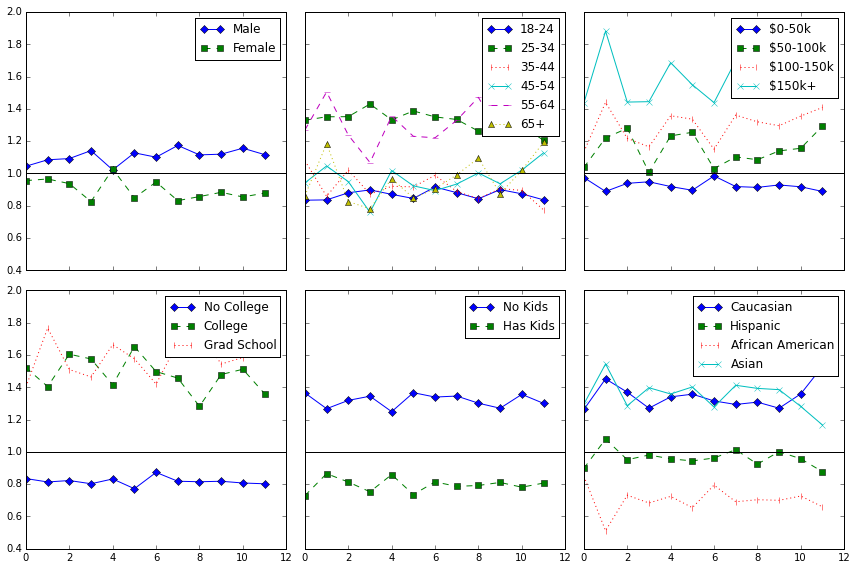

In [274]:
# Now, collects tweets by month and compute the demographic profile of each month based on the sample of users for which we've inferred demographics.
def get_markers():
    markers = []
    for m in Line2D.markers:
        try:
            if len(m) == 1 and m != ' ':
                markers.append(m)
        except TypeError:
            pass
    return markers


def demo_by_month(tweets, user2demo, baseline, categories):
    """ Print demographics by month, optionally by first dividing by the baseline demographics of all twitter. """
    month2demo_list = defaultdict(lambda: [])
    for tweet in tweets:
        screen_name = tweet['username'].lower()
        if screen_name in user2demo:
            month = format_month(tweet['posted_time'])
            month2demo_list[month].append(user2demo[screen_name])
    print 'samples per month:', [len(x) for x in month2demo_list.values()]
    print 'total samples:', sum(len(x) for x in month2demo_list.values())
    month2demo = {}
    for month, d in month2demo_list.iteritems():
        if baseline:
            month2demo[month] = divide_by_baseline(average_demos(d, categories), baseline, categories)
        else:
            month2demo[month] = average_demos(d, categories)
    months = sorted(month2demo.keys())
    figure, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    axes = [x for x in itertools.chain(*axes)]
    markers = get_markers()
    linestyles = ['-', '--', ':']
    for ci, (category, labels) in enumerate(categories.items()):
        print category        
        for li, label in enumerate(labels):
            values = [month2demo[m][category][label] for m in months]
            print '\t', label, ' '.join('%.2f' % v for v in values)
            axes[ci].plot(values, marker=markers[li], label=label, linestyle=linestyles[li % len(linestyles)])
            axes[ci].axhline(y=1, color='k')
            #axes[ci].xaxis_date()
            # axes[ci].set_xticks(months)
            # plt.xticks(rotation=70) 
        axes[ci].legend()
    plt.tight_layout()
    plt.show()
    
demo_by_month(tweets, user2demo, baseline_avg, categories)

**TODO:** Turn above into a bar chart, collapsing months.



the graphs above seem to track the "Awareness%" of Emery's pending publication "Awareness and Use of E-cigarettes among Priority Populations: Role of Smoking Cessation and Tobacco Control Policies"
```
By Age	
18-24	83.9  (80.5 - 87.3)
25-44	88.1  (86.6 - 89.6)
45-64	87.5  (86.2 - 88.8)
65+	82.3  (80.4 - 84.2)

By Gender	
Male 	89.0  (87.8 - 90.1)
Female	84.1  (82.9 - 85.4)

By Race/Ethnicity	
Non-Hispanic White	89.4  (88.6 - 90.3)
Non-Hispanic Black	80.6  (77.4 - 83.8)
Hispanic/Latino	80.0  (77.0 - 83.1)
Other	79.0  (74.9 - 83.2)

By Education	
<High School Grad	78.2  (73.6 - 82.7)
High School Grad	85.6  (84.1 - 87.2)
Some College	88.4  (87.0 - 89.8)
College Grad	87.9  (86.3 - 89.6)
Any Post College	86.5  (84.2 - 88.7)

By Income	
<20,000	84.1  (81.6 - 86.6)
20,000-34,999	85.8  (83.6 - 88.0)
35,000-49,999	84.5  (82.0 - 86.9)
50,000-74,999	87.6  (85.7 - 89.4)
75,000-124,999	87.2  (85.5 - 88.9)
125,000+	88.9  (86.6 - 91.2)

By Sexual Orientation
Heterosexual	86.6  (85.7 - 87.5)
LGB	89.8  (86.5 - 93.1)
```

```
Age		
18-24	1	
25-44	1.13  (0.82 - 1.55)	0.4525
45-64	0.89  (0.66 - 1.21)	0.4494
65+	0.57  (0.41 - 0.79)	0.0006

Gender		
Female	1	
Male	1.37  (1.17 - 1.60)	<.0001

Race		
White	1	
Black	0.52  (0.41 - 0.66)	<.0001
Hispanic	0.47  (0.37 - 0.59)	<.0001
Other	0.41  (0.31 - 0.55)	<.0001

Education		
Less than High School Graduate	1	
High School Graduate	1.52  (1.10 - 2.10)	0.0103
Some College	1.95  (1.40 - 2.72)	<.0001
Bachelor Degree	2.07  (1.46 - 2.95)	<.0001
Any Post College	1.95  (1.34 - 2.83)	0.0005

Income		
<20K	1	
20,000-34,999	1.18  (0.89 - 1.57)	0.2416
35,000-49,999	0.97  (0.73 - 1.29)	0.8480
50,000-74,999	1.20  (0.91 - 1.58)	0.1985
75,000-124,999	1.18  (0.89 - 1.55)	0.2471
125,000+	1.36  (0.97 - 1.90)	0.0743

Sexual Orientation		
Heterosexual	1	
Refused	0.43  (0.26 - 0.72)	0.0012
LGB	1.18  (0.81 - 1.72)	0.3939
```

samples per month: [77, 114, 79, 334, 215, 453, 186, 218, 227, 269, 184, 239]
total samples: 2595
Gender
	Male 0.63 0.60 0.61 0.68 0.55 0.69 0.59 0.67 0.66 0.61 0.66 0.66
	Female 0.37 0.40 0.39 0.32 0.45 0.31 0.41 0.33 0.34 0.39 0.34 0.34
Age
	18-24 0.59 0.55 0.56 0.52 0.56 0.53 0.60 0.55 0.55 0.59 0.61 0.58
	25-34 0.25 0.29 0.32 0.35 0.28 0.28 0.24 0.29 0.24 0.28 0.24 0.20
	35-44 0.04 0.00 0.02 0.04 0.03 0.05 0.03 0.02 0.05 0.04 0.02 0.03
	45-54 0.04 0.12 0.08 0.04 0.08 0.08 0.07 0.07 0.08 0.04 0.06 0.08
	55-64 0.08 0.05 0.03 0.05 0.05 0.05 0.06 0.07 0.07 0.05 0.07 0.10
	65+ 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Income
	$0-50k 0.92 0.92 0.89 0.91 0.84 0.84 0.91 0.87 0.87 0.89 0.87 0.83
	$50-100k 0.01 0.01 0.08 0.02 0.08 0.08 0.05 0.05 0.06 0.05 0.05 0.09
	$100-150k 0.03 0.03 0.02 0.05 0.03 0.05 0.01 0.04 0.03 0.03 0.04 0.04
	$150k+ 0.04 0.04 0.01 0.03 0.05 0.04 0.03 0.05 0.05 0.03 0.04 0.03
Education
	No College 0.72 0.71 0.72 0.72 0.69 0.69 0.76 0.71 0.74 0.74 0

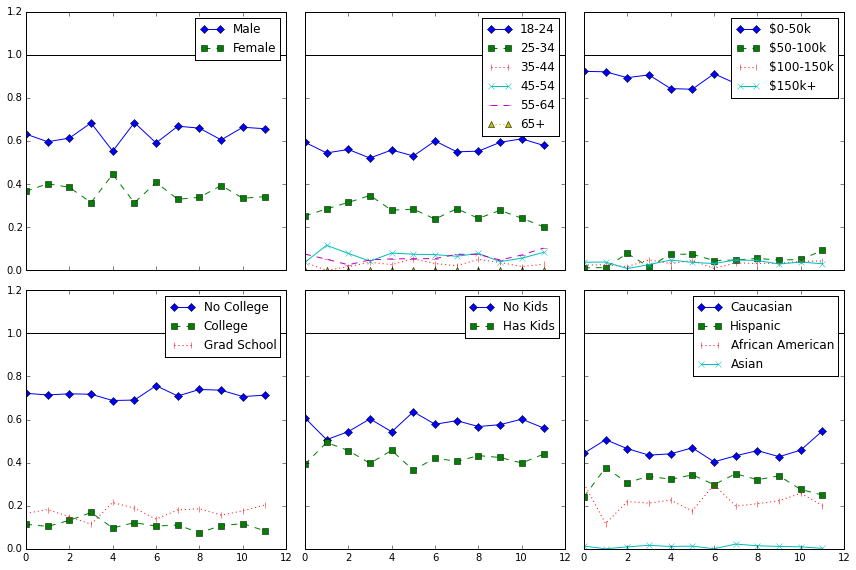

In [275]:
demo_by_month(tweets, classify(user2demo), None, categories)

In [276]:
# TODO: Print top words by demographic (using correlation)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>